# Histogram
Opracowanie: A.Florkowska

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy.ndimage as nd
import scipy.misc
from scipy import ndimage
from skimage import io
from skimage import color
from skimage import exposure
from skimage import filters
import time
from IPython.display import Image

In [2]:
normalize = lambda image: (image - np.min(image)) / (np.max(image) - np.min(image)) 
image = io.imread(".././images/example1.png")
image = image[:,:,0:3]
image = color.rgb2gray(image)
image = normalize(image)

# Histogram - definicja
Obraz jest macierzą pikseli / wokseli. Każdy piksel / woksel ma wartość, odpowiadającą jego intensywności. Histogram obrazu jest statystycznym opisem jego wartości, a więc przedstawia częstość wystąpień pikseli / wokseli danej intensywności na obrazie. 

Histogram zawiera przedziały (kosze), których wartość wskazuje na ilość wystąpień pikseli o intensywności określonej dla każdego przedziału. Użytkownik może sam dobrać liczbę przedziałów lub szerokość pojedynczego przedziału. Ma to bezpośredni wpływ na czytelność i przydatność histogramu do dalszej analizy obrazu.

Funkcja histogram z biblioteki Numpy jako argument przyjmuej obraz wejściowy i liczbę przedziałów, a zwraca dwie listy: liczby zliczeń oraz granice przedziałów. Histogram można wyświetlić w dwóch formach, jednak bardziej popularny i czytelny jest wykres słubkowy. Przed wyświetleniem należy jednak zmodyfikować listę argumentów: zamiast list wartości skrajnych przedziałów, musimy uzyskać listę wartości środka każdego przedziału.

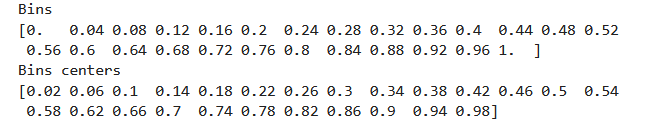

In [16]:
Image(filename=".././images/6_1.png", width=500)

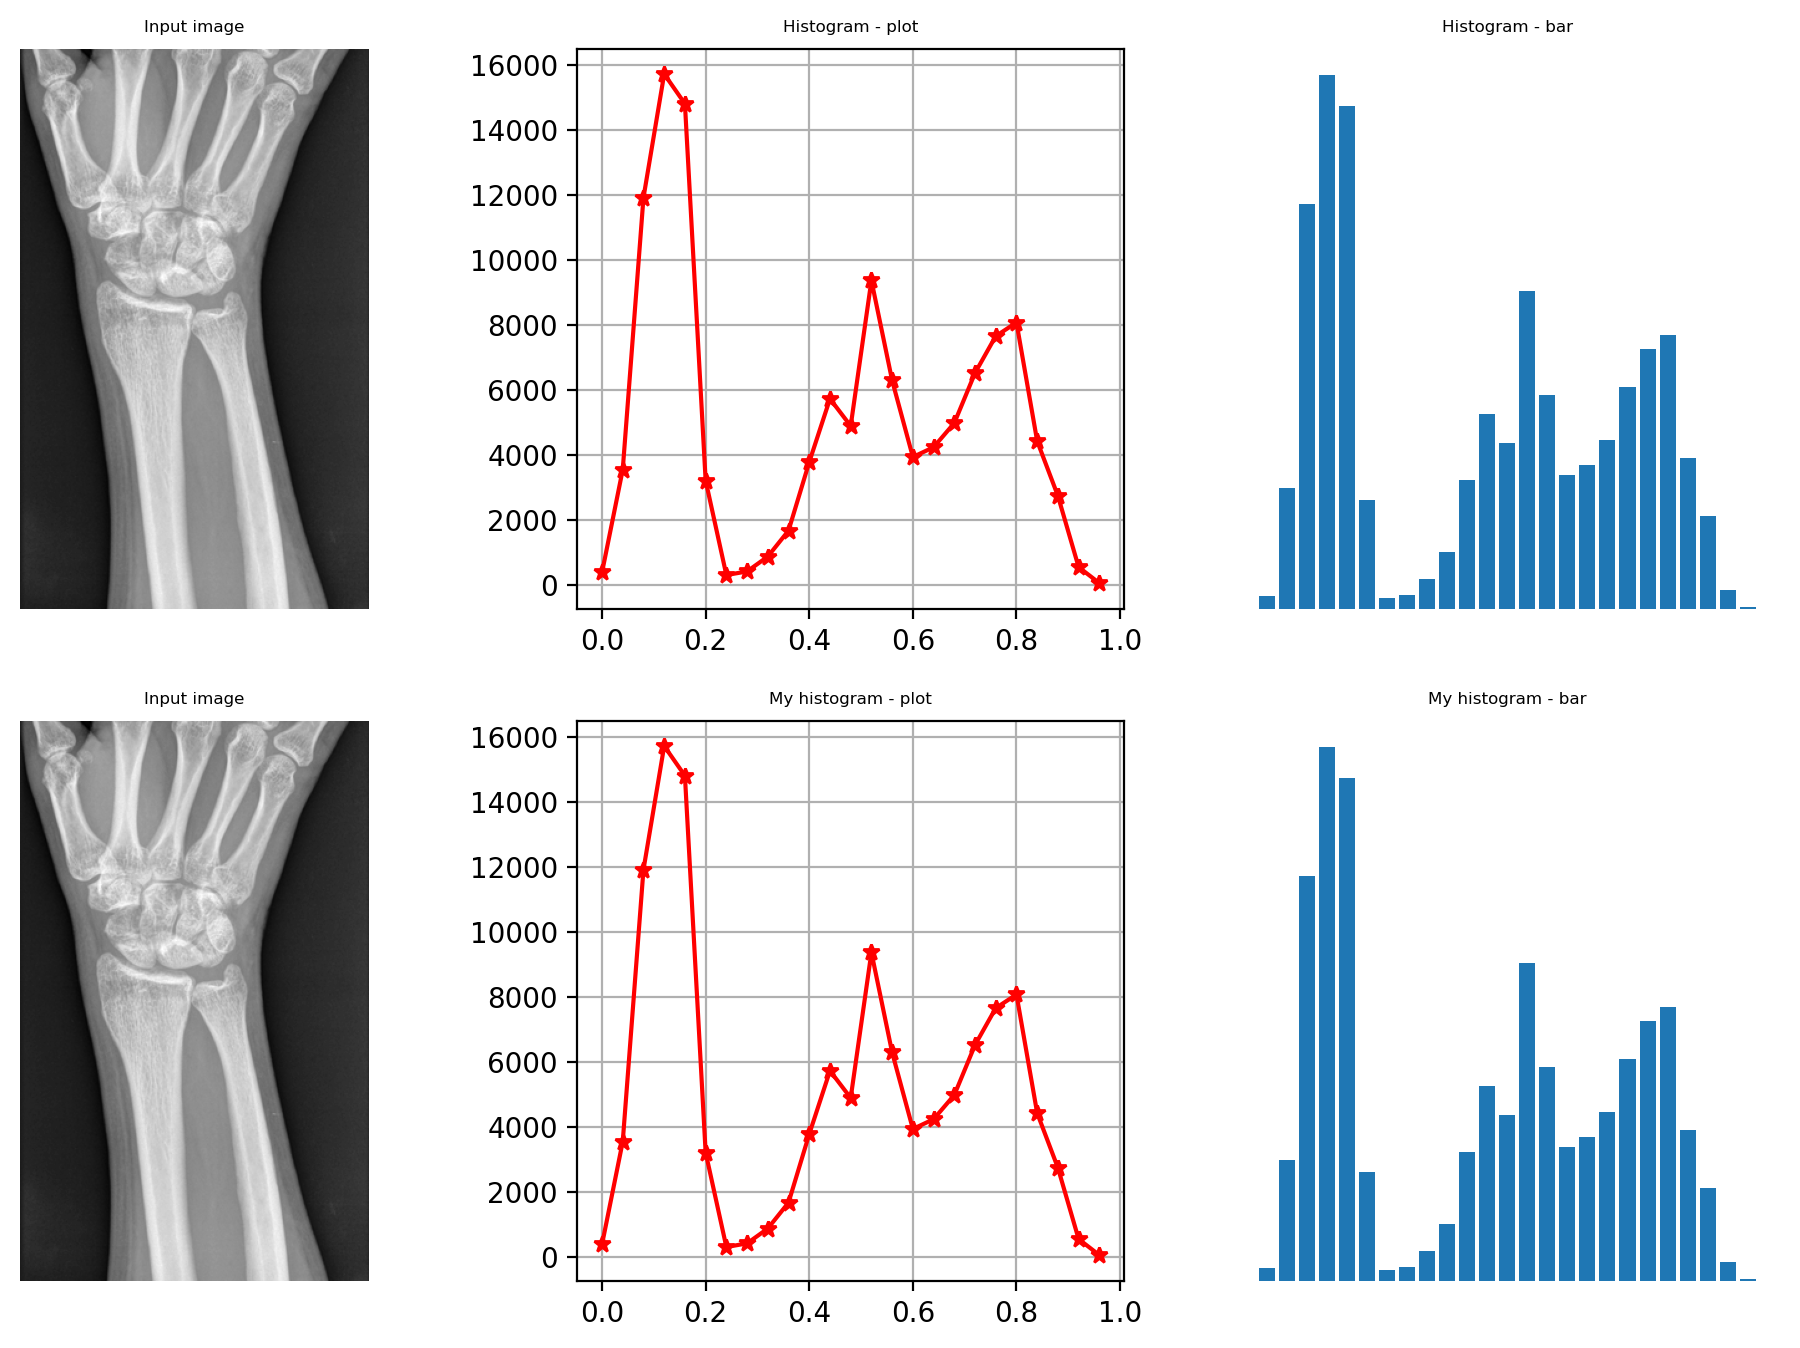

In [26]:
no_bins = 25
np_histogram, bins = np.histogram(image, bins=no_bins)
bins_centers = (bins[:-1] + bins[1:]) / 2
width = (bins[1] - bins[0]) * 0.8

def my_histogram(image, bins_number):
    values_range = image.max() - image.min()
    single_bin = values_range / bins_number
    img_values , img_counts = np.unique(image.ravel(), return_counts=True)
    output_histogram = np.zeros(bins_number)
    output_bins = []
    
    condition = lambda x, low, upper : low <= x < upper
    for i in range(bins_number):
        first_val = image.min() + i * single_bin                   
        last_val = image.min() + (i+1) * single_bin
        indexies = [i for i, val in enumerate(img_values) if condition(val, first_val, last_val)]
        counts_for_selected_indexies = [img_counts[i] for i in indexies]  
        output_histogram[i] = np.sum(counts_for_selected_indexies)
        # It is possible to search 2d image to find elements that meet the condition
        # final_hist[i] = np.sum(img_counts[np.logical_and(img_values >= first_val, img_values < last_val)])
        output_bins.append(first_val)
        
    output_bins.append(last_val)
    output_bins = np.array(output_bins)
    return output_histogram, output_bins

my_histogram, my_bins = my_histogram(image, bins_number=no_bins)
my_bins_centers = (my_bins[:-1] + my_bins[1:]) / 2
my_width = (my_bins[1] - my_bins[0]) * 0.8

plt.figure(figsize=(12, 8), dpi=200)
plt.subplot(2, 3, 1)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title("Input image", fontsize=6)
plt.subplot(2, 3, 2)
plt.plot(bins[:-1], np_histogram, "r*-")
plt.grid(True)
plt.title("Histogram - plot", fontsize=6)
plt.subplot(2, 3, 3)
plt.bar(bins_centers, np_histogram , width=width)
plt.axis('off')
plt.title("Histogram - bar", fontsize=6)
plt.subplot(2, 3, 4)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title("Input image", fontsize=6)
plt.subplot(2, 3, 5)
plt.plot(my_bins[:-1], my_histogram, "r*-")
plt.grid(True)
plt.title("My histogram - plot", fontsize=6)
plt.subplot(2, 3, 6)
plt.bar(my_bins_centers, my_histogram , width=width)
plt.axis('off')
plt.title("My histogram - bar", fontsize=6)
plt.show()

[  0.   0.   0.   0.   0.   0.   0.   0.   1.   1.   2.   2.   3.   4.
   5.   6.   7.   8.   9.  11.  13.  14.  17.  20.  24.  28.  32.  37.
  42.  46.  50.  54.  57.  60.  64.  67.  71.  75.  79.  82.  86.  89.
  91.  94.  96.  98.  99. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 101. 101. 101. 101. 101. 101. 101. 101. 101. 101. 101. 101. 102. 102.
 102. 102. 102. 102. 103. 103. 103. 103. 104. 104. 104. 104. 105. 105.
 105. 106. 106. 107. 107. 108. 109. 110. 111. 112. 113. 115. 116. 117.
 119. 120. 121. 122. 123. 125. 126. 128. 129. 130. 131. 132. 133. 134.
 135. 136. 137. 138. 140. 141. 143. 146. 148. 152. 155. 158. 160. 162.
 163. 165. 166. 167. 168. 169. 170. 171. 172. 173. 173. 174. 175. 176.
 176. 177. 178. 179. 180. 181. 182. 183. 184. 185. 187. 188. 189. 190.
 192. 193. 194. 196. 197. 199. 200. 201. 203. 205. 206. 207. 209. 210.
 212. 214. 215. 217. 219. 221. 223. 225. 227. 229. 231. 233. 234. 236.
 238. 239. 241. 242. 243. 245. 246. 247. 247. 248. 249. 250. 251. 251.
 252. 

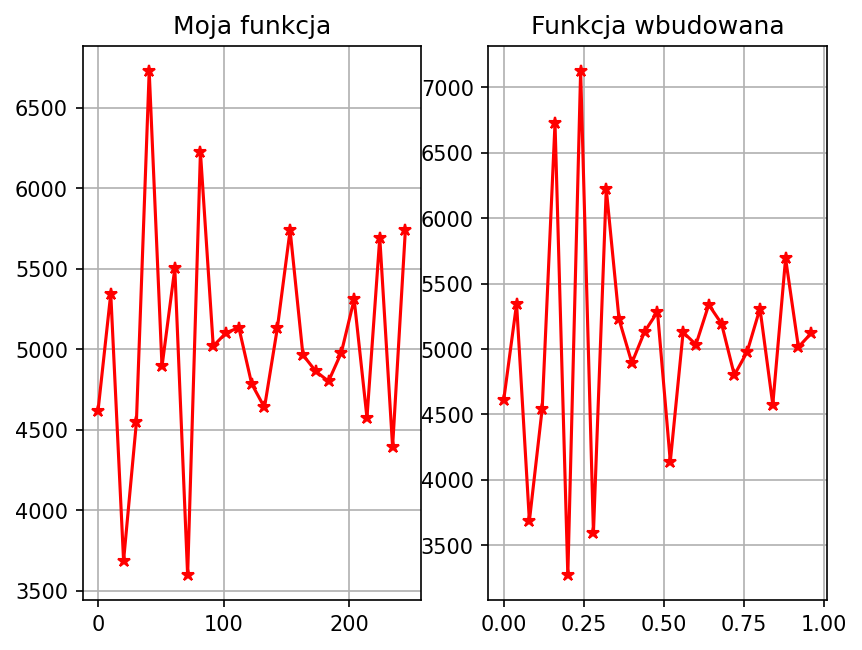

In [21]:
def histogram_equalization(image):
  
  hist_values, hist_index, hist_counts = np.unique(image.ravel(), return_counts=True, return_inverse=True)
  norm_values = np.cumsum(hist_counts).astype(np.float64)
  #norm_values/= norm_values[-1]

  norm_values-= norm_values[0]
  norm_values/= (norm_values[-1] - norm_values[0])
  norm_values*= 255

  norm_values= np.round(norm_values)
  print(norm_values)
  image_equalized = norm_values[hist_index]
  image_equalized = np.reshape(image_equalized, image.shape)
  return image_equalized
  

img = histogram_equalization(image)
our_eq_histogram, our_eq_bins = np.histogram(img.ravel(), bins=no_bins)

img_eq = exposure.equalize_hist(image)
eq_histogram, eq_bins = np.histogram(img_eq.ravel(), bins=no_bins)

plt.figure(dpi=150)
plt.subplot(1,2,1)
plt.plot(our_eq_bins[:-1],our_eq_histogram, "r*-")
plt.title("Moja funkcja")
plt.grid(True)
plt.subplot(1,2,2)
plt.title("Funkcja wbudowana")
plt.plot(eq_bins[:-1], eq_histogram, "r*-")
plt.grid(True)


In [23]:
def histogram_matching(source, target): 
  source_values, source_bins, source_counts = np.unique(source, return_counts=True, return_inverse=True)
  target_values, target_counts = np.unique(target, return_counts=True)

  source_dist = np.cumsum(source_counts).astype(np.float64)
  target_dist = np.cumsum(target_counts).astype(np.float64)
  source_dist /= source_dist[-1]
  target_dist /= target_dist[-1]

  interp_values = np.interp(source_dist, target_dist, target_values)
 
  interp_values = interp_values[source_bins]
  source_matched = interp_values.reshape(source.shape)
  
  return source_matched

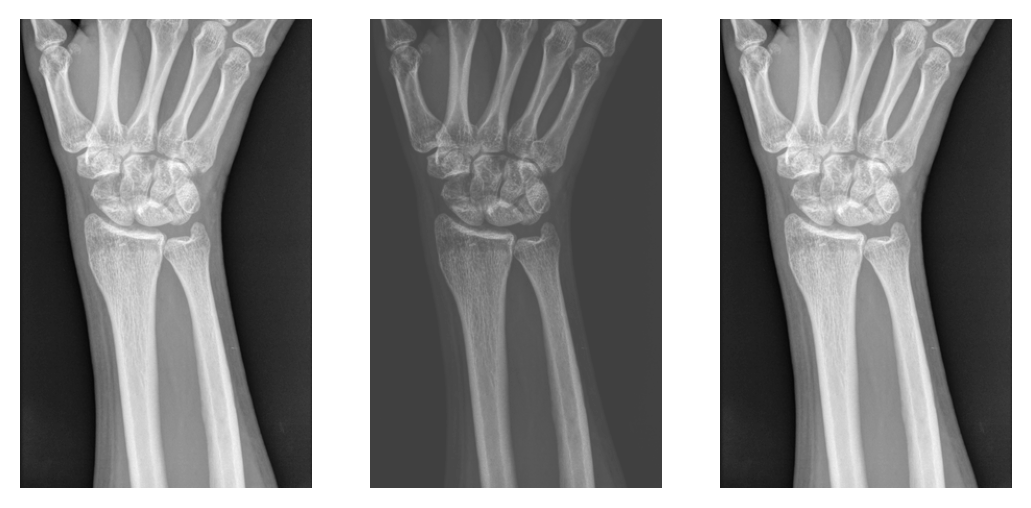

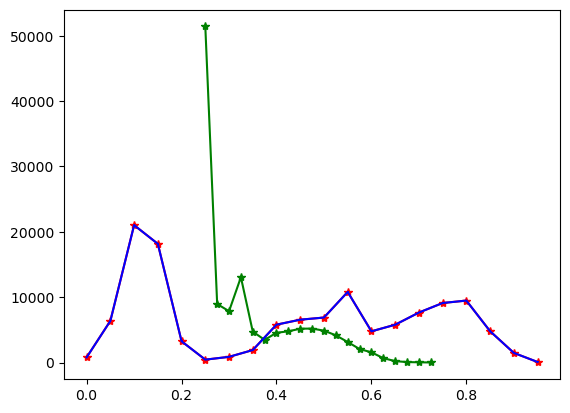

In [24]:
new_image = 0.5*image**3 + 0.25

normalize = lambda image: (image - np.min(image)) / (np.max(image) - np.min(image))

matched_image = normalize(new_image)
matched_image = histogram_matching(new_image, image)

plt.figure(dpi=200)
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(new_image, cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(matched_image, cmap='gray', vmin=0, vmax=1)
plt.axis('off')

no_bins = 20
hist, bins = np.histogram(image, no_bins)
new_hist, new_bins = np.histogram(new_image, no_bins)
matched_hist, matched_bins = np.histogram(matched_image, no_bins)


plt.figure(dpi=100)
plt.plot(bins[:-1], hist, "r*-")
plt.plot(new_bins[:-1], new_hist, "g*-")
plt.plot(matched_bins[:-1], matched_hist, "b,-")

plt.show()